# Перечень акваторий, используемых для парсинга

Перечисление и визуализация списка зон, используемых для парсинга

In [191]:
import os
import re
import numpy as np
import h5py
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.colors import to_rgba
from matplotlib.patches import Patch

In [192]:
dataset_path = "/Volumes/SSD/mark/Documents/Works/MT_Dataset/mt_master_20250714.h5"

In [193]:
zones = []
with h5py.File(dataset_path, "r") as ds:
    for attr in ds.attrs:
        print(f"{attr}: {ds.attrs[attr]}")
    print(ds["zones"].dtype)
    print(f"Zones count: {len(ds["zones"])}")
    zones = ds["zones"][()]

author: Mark Vodyanitskiy (mvodya@icloud.com)
created_at: 2025-07-13T14:26:08.378871
sources_count: 27555
sources_size: 439.3Gb
version: 1.0
[('zone_id', '<i8'), ('name', 'S256'), ('lat', '<f4'), ('lon', '<f4'), ('zoom', '<i4')]
Zones count: 194


In [194]:
zones[()]["zoom"][zones["zoom"] == 10]

array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10], dtype=int32)

In [195]:
# Получаем список всех используемых маштабов
np.unique(zones[()]["zoom"])

array([ 1,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14], dtype=int32)

In [196]:
# Выделение базового имени группы
def extract_group(name_bytes):
    name = name_bytes.decode('utf-8').strip()
    # Удаляем завершающее число, если оно есть
    match = re.match(r"^(.*?)(?:\s+\d+)?$", name)
    return match.group(1).strip() if match else name

# Извлекаем все группы
group_names = set(extract_group(z['name']) for z in zs)
group_names

{'Бухта Улисс',
 'Весь регион',
 'Внутренее Японское море',
 'Гонконг',
 'Гуанчжоу',
 'Залив Петра Великого',
 'Нагоя',
 'Находка',
 'Осака',
 'Порт Владивосток',
 'Пусан',
 'Сангарский пролив',
 'Сингапур',
 'Токийский Залив',
 'Хиросима',
 'Япония'}

/var/folders/2c/2p1h64qd4zb1g13m_f5z4z9w0000gn/T/ipykernel_54897/3519662057.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(group_names))


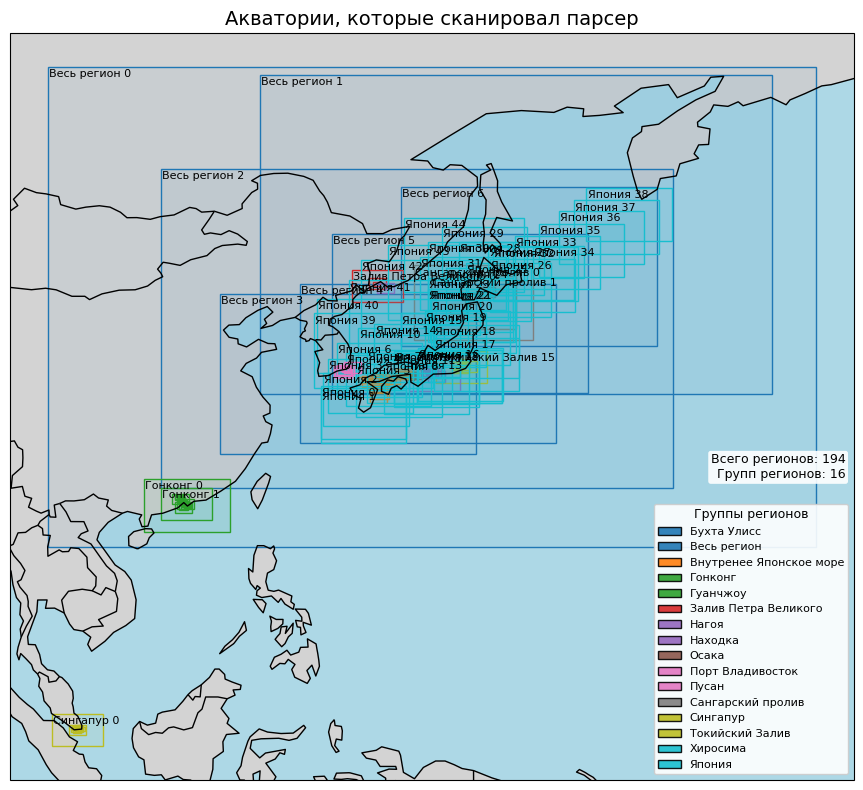

In [199]:
# Соотношение сторон регионов скана
aspect_ratio = 16 / 10

# Откалиброванные преобразования маштабов
zoom_scale = {
    4: 45,
    5: 30,
    6: 15,
    7: 7,
    8: 5,
    9: 3,
    10: 1,
    11: 0.5,
    12: 0.4,
    13: 0.2,
    14: 0.1
}

# Вычисление границ карты
min_lat, max_lat = float('inf'), -float('inf')
min_lon, max_lon = float('inf'), -float('inf')

# Фильтруем + фикс мелкого косяка в данных
zs = zones[(zones["zoom"] != 1) & (zones["lat"] < 300)]

for zone in zs:
    lat = zone['lat']
    lon = zone['lon']
    zoom = zone['zoom']
    size = zoom_scale.get(zoom, 1)
    h = size
    w = size * aspect_ratio

    min_lat = min(min_lat, lat - h / 2)
    max_lat = max(max_lat, lat + h / 2)
    min_lon = min(min_lon, lon - w / 2)
    max_lon = max(max_lon, lon + w / 2)

# Добавим небольшой отступ (в градусах)
lat_pad = (max_lat - min_lat) * 0.05
lon_pad = (max_lon - min_lon) * 0.05

# Рисуем карту
fig, ax = plt.subplots(figsize=(12, 8),
                       subplot_kw={'projection': ccrs.PlateCarree()})
# ax.set_extent([125, 150, 30, 50], crs=ccrs.PlateCarree())
ax.set_extent([min_lon - lon_pad, max_lon + lon_pad,
               min_lat - lat_pad, max_lat + lat_pad],
              crs=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Назначаем уникальный цвет каждому имени
cmap = cm.get_cmap('tab10', len(group_names))
group_to_color = {name: mcolors.to_hex(cmap(i)) for i, name in enumerate(sorted(group_names))}

# Рисуем регионы
for zone in zs:
    lat = zone['lat']
    lon = zone['lon']
    zoom = zone['zoom']
    label = zone['name'].decode('utf-8')
    size = zoom_scale.get(zoom, 5)

    height = size
    width = size * aspect_ratio

    # Получаем цвет группы
    group = extract_group(zone['name'])
    color = group_to_color[group]
    face = to_rgba(color, alpha=0.05)

    # Рисуем прямоугольник
    rect = Rectangle((lon - width / 2, lat - height / 2),
                     width, height,
                     linewidth=1, edgecolor=color,
                     facecolor=face,
                     transform=ccrs.PlateCarree())
    ax.add_patch(rect)

    # Подпись
    if zoom < 10:
        ax.text(lon - width / 2 + 0.1, lat + height / 2 - 0.2,
                label, fontsize=8, color='black',
                transform=ccrs.PlateCarree(),
                ha='left', va='top')

# Доп информация
ax.text(
    0.99, 0.4,
    f"Всего регионов: {len(zones)}\nГрупп регионов: {len(group_names)}",
    fontsize=9,
    color='black',
    ha='right',
    va='bottom',
    transform=ax.transAxes,
    bbox=dict(facecolor='white', edgecolor='none', alpha=0.9, boxstyle='round,pad=0.2')
)

# Создаём элементы легенды
legend_elements = [
    Patch(facecolor=color, edgecolor='black', label=group, alpha=0.9)
    for group, color in group_to_color.items()
]

# Добавляем легенду
ax.legend(handles=legend_elements,
          title="Группы регионов",
          loc='lower right',
          fontsize=8,
          title_fontsize=9,
          frameon=True,
          facecolor='white',
          framealpha=0.9)

plt.title("Акватории, которые сканировал парсер", fontsize=14)
plt.tight_layout()
plt.show()

In [224]:
# Папка для кадров
output_dir = "output/zone_animation_frames_0"

# Окно (кол-во зон на одном кадре)
window_size = 40
frame_count = len(zs)

# Создаём элементы легенды
legend_elements = [
    Patch(facecolor=color, edgecolor='black', label=group, alpha=0.9)
    for group, color in group_to_color.items()
]

# Рендерим анимацию (перебор кадров)
for i in range(frame_count + window_size - 1):
    # Выделяем зоны на кадре
    if i < window_size:
        # Начальные кадры — постепенно наращиваем количество зон
        visible_zones = zs[0 : i + 1]
    else:
        # После — скользящее окно
        visible_zones = zs[i - window_size + 1 : i + 1]

    fig, ax = plt.subplots(figsize=(12, 8),
                           subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([min_lon - lon_pad, max_lon + lon_pad,
                   min_lat - lat_pad, max_lat + lat_pad],
                  crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

    # Перебираем все зоны, кроме последней
    for zone in visible_zones[:-1]:
        lat = zone['lat']
        lon = zone['lon']
        zoom = zone['zoom']
        label = zone['name'].decode('utf-8')
        size = zoom_scale.get(zoom, 5)
        height = size
        width = size * aspect_ratio

        group = extract_group(zone['name'])
        color = group_to_color[group]
        face = to_rgba(color, alpha=0.08)

        rect = Rectangle((lon - width / 2, lat - height / 2),
                         width, height,
                         linewidth=1, edgecolor=color,
                         facecolor=face,
                         transform=ccrs.PlateCarree())
        rect.set_clip_on(True)
        rect.set_clip_path(ax.patch)
        ax.add_patch(rect)

        if zoom < 12:
            text = ax.text(lon - width / 2 + 0.1, lat + height / 2 - 0.2,
                           label, fontsize=8, color='black',
                           transform=ccrs.PlateCarree(),
                           ha='left', va='top')
            text.set_clip_on(True)
            text.set_clip_path(ax.patch)
    
    # Рисуем последнюю зону
    zone = visible_zones[-1:][0]
    lat = zone['lat']
    lon = zone['lon']
    zoom = zone['zoom']
    label = zone['name'].decode('utf-8')
    size = zoom_scale.get(zoom, 5)
    height = size
    width = size * aspect_ratio

    group = extract_group(zone['name'])
    color = group_to_color[group]
    face = to_rgba(color, alpha=0.5)

    rect = Rectangle((lon - width / 2, lat - height / 2),
                        width, height,
                        linewidth=1, edgecolor=color,
                        facecolor=face,
                        transform=ccrs.PlateCarree())
    rect.set_clip_on(True)
    rect.set_clip_path(ax.patch)
    ax.add_patch(rect)
    text = ax.text(lon - width / 2 + 0.1, lat + height / 2 - 0.2,
                    label, fontsize=8, color='red',
                    transform=ccrs.PlateCarree(),
                    ha='left', va='top',
                    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2', alpha=1))
    text.set_clip_on(True)
    text.set_clip_path(ax.patch)

    # Доп информация
    ax.text(
        0.99, 0.43,
        f"Всего кадров: {frame_count}\nТекущий кадр: {i}\nРазмер скользящего окна: {window_size}\nОтображаемых зон: {len(visible_zones)}",
        fontsize=9,
        color='black',
        ha='right',
        va='bottom',
        transform=ax.transAxes,
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.9, boxstyle='round,pad=0.2')
    )
    ax.text(
        0.01, 0.01,
        f"Текущая зона: {label}",
        fontsize=9,
        color='black',
        ha='left',
        va='bottom',
        transform=ax.transAxes,
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.9, boxstyle='round,pad=0.2')
    )
    ax.text(
        0.01, 0.04,
        f"Lat: {lat}\nLon: {lon}\nZoom: {zoom} ({size})",
        fontsize=6,
        color='black',
        ha='left',
        va='bottom',
        transform=ax.transAxes,
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.9, boxstyle='round,pad=0.2')
    )

    # Добавляем легенду
    ax.legend(handles=legend_elements,
            title="Группы регионов",
            loc='lower right',
            fontsize=8,
            title_fontsize=9,
            frameon=True,
            facecolor='white',
            framealpha=0.9)

    ax.set_title("Процесс работы парсера при сканировании акваторий", fontsize=14)
    plt.tight_layout()
    frame_path = os.path.join(output_dir, f"frame_{i:04d}.png")
    plt.savefig(frame_path, bbox_inches='tight', dpi=150)
    plt.close()

In [225]:
%cd output/zone_animation_frames_0

# Генерируем палитру
!ffmpeg -y -framerate 20 -i frame_%04d.png -vf palettegen palette.png

# Создаем gif с использованием палитры
!ffmpeg -y -framerate 20 -i frame_%04d.png -i palette.png -lavfi paletteuse zone_animation_0.gif

%cd ../../

/Volumes/SSD/mark/Documents/Projects/marinetraffic-collector/research/output/zone_animation_frames_0
ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 16.0.0 (clang-1600.0.26.6)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_2 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enabl